# 无监督学习简介

在本实验中，您将使用**无监督学习**。无监督学习试图在复杂数据中找到固有的结构或关系。与监督学习相比，无监督学习不使用标记。

有许多无监督学习的方法。在本实验中，您将使用两种广泛使用的**聚类**方法，**K-means聚类**和**层次**。

## K-means聚类

K均值聚类将数据集分离为具有相等方差的K个聚类。簇的数量K是用户定义的。基本算法包括以下步骤：
1. 随机选择一组K质心。
2. 通过最小化每个群集内的方差来形成群集。此度量标准也称为**误差平方和**中的（请参阅有关评估集群的部分中的进一步讨论）。此步骤将数据划分为群集，其中距群集质心的距离最小。
3. 质心移动到每个簇的平均值。计算每个聚类的平均值，并将质心移动到平均值。
4. 重复步骤2和3，直到满足停止标准。通常，当内部群集方差仅最小程度地减小时，算法终止。
5. 从步骤1的随机开始重复上述步骤。保留在簇方差内和簇分离之间的最佳簇集合。

由于K均值聚类仅依赖于基本线性代数运算，因此该方法可大规模扩展。核外K-means聚类算法被广泛使用。但是，该方法假设聚类的方差相等，这是一个相当严格的假设。在实践中，这个标准几乎从来都不是一定的，但K-means聚类仍然会产生有用的结果。

## 分层聚类

与K-means方法相比，分层聚类方法可以减少分布假设。但是，K-means方法通常更具可扩展性，有时甚至更高。

分层聚类通过**分裂**方法或**凝聚**方法创建聚类。分裂方法是一种“自上而下”的方法，从整个数据集开始，然后以逐步的方式查找分区。后一种方法被称为凝聚聚类是一种“自下而上”的方法。在本实验中，您将使用凝聚聚类，其大致如下工作：
1. 计算每个数据点之间的**连接距离**。
2. 点与最近邻居成对聚类。
3. 计算簇之间的链接距离。
4. 将群集成对组合成更大的群集。
5. 重复步骤3和4，直到所有数据点都在一个簇中。

链接功能可以通过多种方式计算：
 -  **Ward**链接测量链接集群的方差增加，
 -  **平均**链接使用两个簇的成员之间的平均成对距离，
 -  **完整**或**最大**链接使用两个簇的成员之间的最大距离。

几个不同的距离度量用于计算链接函数：
 -  **Euclidian**或**l2**距离是最广泛使用的。此度量标准仅适用于Ward链接方法。
 -  **曼哈顿**或**l1**距离对异常值很强，并具有其他有趣的属性。
 -  **余弦相似度***，是位置向量之间的点积除以向量的大小。请注意，此度量标准是相似性的度量，而其他两个度量标准是差异度量。在处理图像或文本文档等数据时，相似性非常有用。




## 第一个例子

考虑到上述理论，您现在将K-means和凝聚聚类模式应用于一组合成数据。

首先，执行下面单元格中的代码以加载运行此其余部分所需的包。


In [23]:
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

%matplotlib inline

下面单元格中的代码创建服从二元正态分布的合成数据，均值为$\{ 0,0 \}$，协方差矩阵：

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.4 \\
  0.4 & 1.0
 \end{bmatrix}$$
 

In [53]:
def make_dist(mean, cov, dist_num, n = 100, seed = 123):
    nr.seed(seed)
    sample = nr.multivariate_normal(mean, cov, n) # Compute the 2-d Normally distributed data
    sample = np.column_stack((sample, np.array([dist_num]*n))) ## Add the distribution identifier
    print('Shape of sample = ' + str(sample.shape))
    return(sample)

cov = np.array([[1.0, 0.4], [0.4, 1.0]])
mean = np.array([0.0, 0.0])
sample1 = make_dist(mean, cov, 1)

Shape of sample = (100, 3)


执行下面单元格中的代码，从两个不同的分布中创建模拟数据：

In [25]:
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
mean = np.array([3.0, 0.0])
sample2 = make_dist(mean, cov, 2, 100, 3344)

mean = np.array([-3.0,0.0])
cov = np.array([[1.0,0.8],[0.8,1.0]])
sample3 = make_dist(mean, cov, 3, 100, 5566)

Shape of sample = (100, 3)
Shape of sample = (100, 3)


执行下面单元格中的代码以显示服从三个分布的模拟数据集。

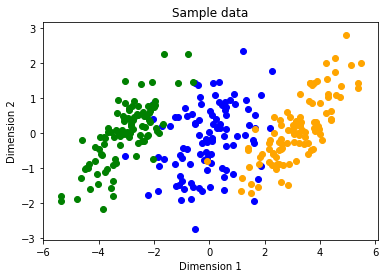

In [26]:
def plot_dat(sample1, sample2, sample3):
    plt.scatter(sample1[:,0], sample1[:,1], color = 'blue')
    plt.scatter(sample2[:,0], sample2[:,1], color = 'orange')
    plt.scatter(sample3[:,0], sample3[:,1], color = 'green')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Sample data')
    plt.show()
    
plot_dat(sample1, sample2, sample3)  

请注意，这三个分布大多是分开的，有些重叠。

执行下面单元格中的代码以连接三个numpy数组中的数据，并对Z-Score标准化特征列，对任何人来说这都是至关重要的一步：

In [27]:
sample = np.concatenate((sample1, sample2, sample3))

for i in range(1):
    mean_col = np.mean(sample[:,i])
    std_col = np.std(sample[:,i])
    sample[:,i] = [(x - mean_col)/std_col for x in sample[:,i]]

sample.shape

(300, 3)

接下来，您将通过以下代码中的以下步骤创建K-means聚类模型：
1. K-means聚类模型定义为K = 3。
2. 该模型适合于计算的数据和聚类分配。
3. 打印群集的分配。

执行此代码。



In [28]:
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(sample[:,0:2])
print(assignments_km3)

[0 1 0 2 1 2 1 2 1 1 0 0 2 1 2 1 2 1 0 2 2 0 0 1 0 2 1 0 0 1 0 1 1 0 2 1 1
 2 0 2 1 1 2 2 1 1 0 0 2 1 1 0 0 1 1 0 0 1 2 1 2 0 1 1 1 2 0 1 0 1 2 1 1 0
 0 0 2 2 1 1 0 0 1 1 0 2 2 0 1 0 0 1 1 2 0 0 0 1 0 0 1 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2
 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0
 0 0 0 0]


执行下面单元格中的代码以绘图：

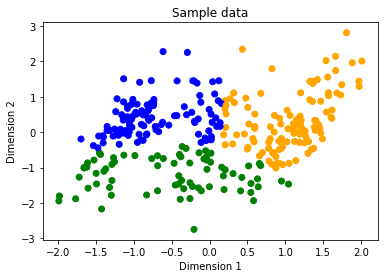

In [29]:
def plot_clusters(sample, assignment):
    col_dic = {0:'blue',1:'green',2:'orange',3:'gray',4:'magenta',5:'black'}
    colors = [col_dic[x] for x in assignment]
    plt.scatter(sample[:,0], sample[:,1], color = colors)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Sample data')
    plt.show()

plot_clusters(sample, assignments_km3)

检查这个图， k均值聚类算法在数据中发现了一种与用于生成它们的分布完全不同的结构。 尽管如此，鉴于数据的结构，这些集群看起来是合理的。 聚类将数据分成三个相当紧密的区域：


现在，您将比较K-means聚类的结果与凝聚聚类，下面单元格中的代码执行以下处理：
1. 定义具有三个聚类的凝聚聚类模型。
2. 适合模型并计算群集分配。

执行此代码：

In [30]:
agglomerative_3 = AgglomerativeClustering(n_clusters=3)
assignments_ag3 = agglomerative_3.fit_predict(sample[:,0:2])

执行下面单元格中的代码，以显示凝聚模型的聚类分配。

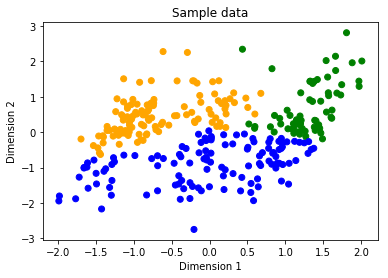

In [31]:
plot_clusters(sample, assignments_ag3)

凝聚聚类模型的结果与k均值模型的结果明显不同，凝聚簇偏离由k均值算法产生的近似椭圆簇。

将上述3个聚类模型应用于三个模拟分布，使用其他数量的聚类会有什么结果？

执行下面单元格中的代码以计算K-means集群模型，K = 4，并显示分配。

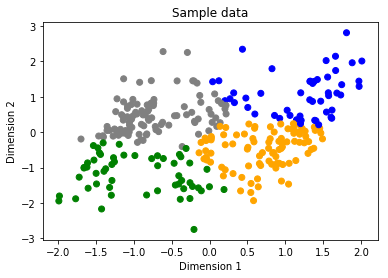

In [32]:
kmeans_4 = KMeans(n_clusters=4, random_state=0)
assignments_km4 = kmeans_4.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_km4)

要将K-means模型与具有两个聚类的凝聚聚类模型进行比较，请执行下面单元格中的代码。

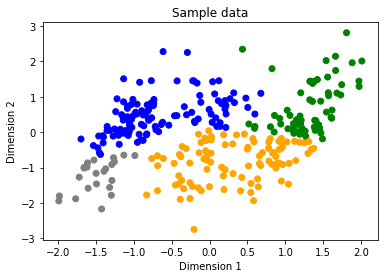

In [33]:
agglomerative_4 = AgglomerativeClustering(n_clusters=4)
assignments_ag4 = agglomerative_4.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_ag4)

将这些结果相互比较并与3个群集模型进行比较。 正如所料，4个簇模型展示了较小的簇，显示了数据结构的更多细节。 发现的结构在k均值和凝聚模型之间明显不同。

接下来，您将探索K-means和凝聚聚类方法与5个聚类之间的差异。 执行下面单元格中的代码以计算K = 5 K-means模型并显示分配。


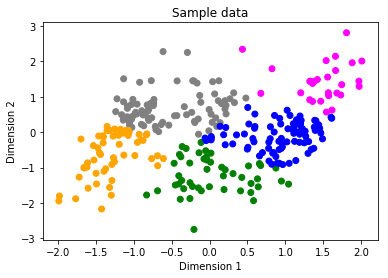

In [34]:
kmeans_5 = KMeans(n_clusters=5, random_state=0)
assignments_km5 = kmeans_5.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_km5)

接下来，执行下面单元格中的代码，计算并显示具有5个聚类的凝聚聚类模型的分配。

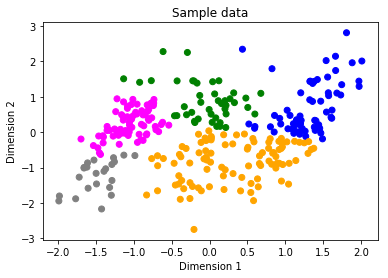

In [35]:
agglomerative_5 = AgglomerativeClustering(n_clusters=5)
assignments_ag5 = agglomerative_5.fit_predict(sample[:,0:2])
plot_clusters(sample, assignments_ag5)

检查K-means和凝聚聚类方法的分配之间的差异。 请注意，K-means方法创建了5个聚类，这些聚类明显不同于凝聚模型的结构。 每个模型都突出了数据结构的不同方面。



## 评估集群模型

现在您已经创建了一些聚类模型，您可能想知道如何评估这些模型并执行模型选择。 您可以使用许多指标来评估和比较群集模型。 但是，您应该始终牢记，应根据您尝试解决的问题选择最佳模型。

集群的一个有用指标是**簇内平方和**或**WCSS**。直观地说，簇应具有最小的发散，因此WCSS最小。

$$WCSS = Min \sum_i \sum_{j\ in\ cluster\ i} ||x_j - c_i||^2 \\
where\\
c_i = center\ of\ ith\ cluster\\ 
and\\
||x_j - c_i|| = distance\ between\ data\ x_j\ and\ center\ c_i
$$

我们可以使用WCSS来比较不同的集群模型。 具有较小SSW的模型具有更紧密的簇，因此具有更小的WCSS。

****
**注意：** WCSS也称为**inertia**。
****

**簇间的平方和**或**BCSS**是相关度量，而WCSS测量群集的紧密程度BCSS是群集之间分离的度量。请注意是**总平方和**是**TSS**必须等于WCSS和BCSS的总和：


$$
TSS = BCSS + WCSS\\
where\\
TSS = \sum_i (x_i - \mu)^2\\
where\\
\mu = mean\ of\ all\ data\ samples
$$

请注意，TSS只是所有数据点的方差，那么BCSS就是TSS和WCSS之间的区别。

**轮廓系数**或**SC**是另一个聚类度量。 轮廓系数测量簇内距离与距离最近的相邻簇的距离之间的比率。 群集的$ith$成员的SC计算如下：

$$
SC_i = \frac{b_i -a_i }{max(a_i, b_i)}\\
where\\
a_i = average\ distance\ from\ point\ i\ to\ other\ members\ of\ the\ same\ cluster\\
b_i = average\ distance\ from\ point\ i\ to\ members\ of\ an\ adjacent\ cluster
$$

首先SC具有一些重要属性，SC值因标准化而受到限制：

$$\{ -1 \le SC \le 1 \}$$

对于群集紧凑且与相邻群集良好分离的情况，以下关系成立：

$$if\ a_i \lt b_i\ then\ SC \gt 0$$

但是，对于与相邻群集分离不良的分散群集，以下关系成立：

$$if\ a_i \gt b_i\ then\ SC \lt 0$$

换句话说，群集越紧密，它就越远离相邻群集的成员。 SC值越接近1.但是，如果群集是分散的并且到相邻群集的距离很小，则SC将具有小于0的值。

总之，您希望找到SC值接近1的模型。如果SC始终小于零，则聚类模型可能没那么有用。

****
**注意** WCSS和BCSS指标具有聚类的概念要求簇具有多变量-正态分布。 因此，这些指标严格仅适用于K均值集群。这一事实意味着WCSS和BCSS不是凝聚聚类的有用指标。可以使用各种度量来计算SC，因此更一般地适用于大多数聚类方法。
****


在上一节中，您使用可视化比较了聚类模型。 下面单元格中的代码计算并显示了尝试的三个K-means聚类模型的WCSS和BCSS。 执行此代码并检查结果。

[218.118920062178, 157.80708909786227, 122.86119030810535]
[300.]


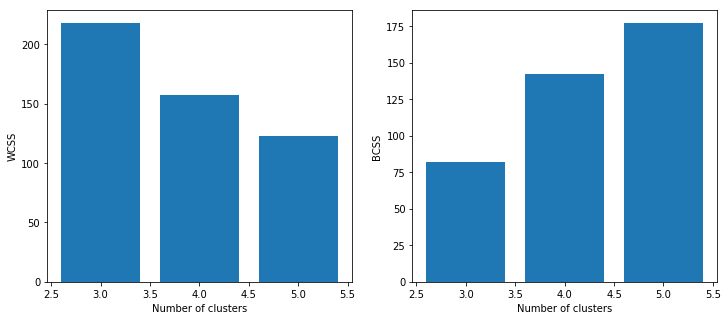

In [36]:
km_models = [kmeans_3, kmeans_4, kmeans_5]

def plot_WCSS_km(km_models, samples):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in km_models]
    print(wcss)
    n_clusts = [x+1 for x in range(2,len(wcss) + 2)]
    ax[0].bar(n_clusts, wcss)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    ## Plot BCSS
    tss = np.sum(sample[:,0:1]**2, axis = 0)
    print(tss)
    ## Compute BCSS as TSS - WCSS
    bcss = np.concatenate([tss - x for x in wcss]).ravel()
    ax[1].bar(n_clusts, bcss)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    plt.show()
    

plot_WCSS_km(km_models, sample)

检查这些结果并注意以下事项：
1. WCSS随着集群的数量而减少，而BCSS随着集群的数量而增加，此行为是符合预期的。 使用更多群集会导致较小的群集和较低的WCSS。 然而，簇之间的分离随着簇的数量增加而减少，导致BCSS增加。
2. WCSS在3到4个集群之间显着减少。4和5集群模型之间的两个指标的变化较小。
3. 这些指标表明4和5集群模型之间没有太大差异。 然而，3簇模型似乎较差。

下面单元格中的代码计算并显示三个M-means模型的SC。 此代码使用scikit-learn`metrics`包中的`silhouette_score`函数。 执行此代码并检查结果。


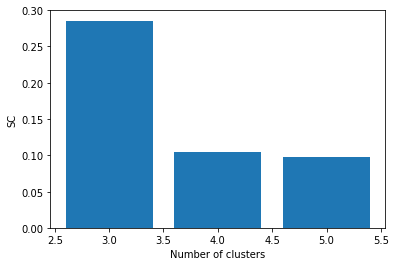

In [37]:
assignment_list = [assignments_km3, assignments_km4, assignments_km5]

def plot_sillohette(samples, assignments, x_lab = 'Number of clusters', start = 3):
    silhouette = [silhouette_score(samples[:,0:1], a) for a in assignments]
    n_clusts = [x + start for x in range(0, len(silhouette))]
    plt.bar(n_clusts, silhouette)
    plt.xlabel(x_lab)
    plt.ylabel('SC')
    plt.show()

plot_sillohette(sample, assignment_list)

SC随着簇数的增加而减少，4和5簇模型具有相当低的SC。

总的来说，三个指标表明k = 5 k-means模型是最具代表性的。 虽然k = 3模型具有更高的SC，但WCSS更大并且BCSS更低。

使用k均值聚类模型的探索可以扩展到更多数量的聚类。

下面单元格中的代码计算并显示三个凝聚聚类模型的SC，执行此代码并检查结果：

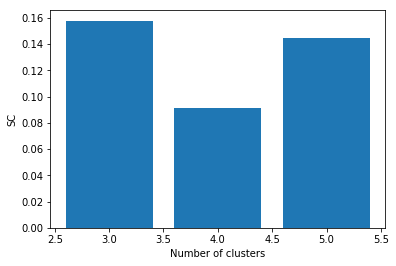

In [39]:
assignment_list = [assignments_ag3, assignments_ag4, assignments_ag5]
plot_sillohette(sample, assignment_list)

SC类似于3和5簇模型，看起来5簇模型已经创建了原始3个簇的更精细的划分。 对于层次聚类模型，此行为是预期的。 这些模型中的聚类划分是基于树结构的分割。


## 另一个例子

上述实施例提供了对K均值和凝聚聚类的基本介绍。 在本节中，您将使用另一组合成数据，并探索距离度量和连接函数的变化如何改变凝聚聚类结果。

下面单元格中的代码计算由三个分布组成的另一个合成数据集。 其中一个分布具有比前一个示例大得多的协方差。 这一事实将强调K均值聚类模型的等方差假设。

执行此代码以生成和显示数据集。


In [ ]:
nr.seed(3344)
cov = np.array([[1.0, -0.98], [-0.98, 1.0]])
mean = np.array([-1.0, 0.0])
sample1 = make_dist(mean, cov, 1, 100, 3344)

nr.seed(5566)
cov = np.array([[1.0, -0.8], [-0.8, 1.0]])
mean = np.array([6.0, 0.0])
sample2 = make_dist(mean, cov, 1, 100, 6677)

nr.seed(7777)
cov = np.array([[1.0, 0.9], [0.9, 1.0]])
mean = np.array([-4.0, 0.0])
sample3= make_dist(mean, cov, 3, 100, 367)

## Plot the distributions
plot_dat(sample1, sample2, sample3) 

正如预期的那样，数据集由三个不同的分布组成。 中心的分布表现出高协方差。

现在，执行下面单元格中的代码，将三个分布连接成一个numpy数组，并将Z-Score标准化。

In [40]:
sample_2 = np.concatenate((sample1, sample2, sample3))

for i in range(1):
    mean_col = np.mean(sample_2[:,i])
    std_col = np.std(sample_2[:,i])
    sample_2[:,i] = [(x - mean_col)/std_col for x in sample_2[:,i]]

sample_2.shape

(300, 3)

K = 3 K-means模型是比较的有用的，执行下面单元格中的代码以计算模型并显示集群分配。

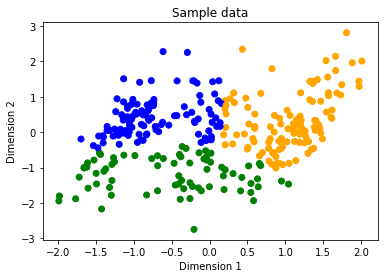

0.2855226149210479


In [41]:
nr.seed(3344)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments_km3)
print(silhouette_score(sample_2[:,0:1], assignments_km3))

k = 3 K-means聚类模型在很大程度上将右侧数据分开，并在左侧分割数据分布。

现在，通过执行下面单元格中的代码，使用Ward链接和欧几里德距离规范（scikit-learn中的默认值）计算3-cluster凝聚模型。

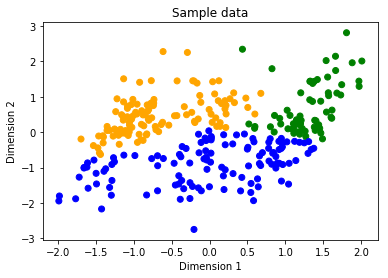

In [47]:
nr.seed(3344)
agglomerative3_w = AgglomerativeClustering(n_clusters=3)
assignments3_w = agglomerative3_w.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_w)

上面显示的群集分配主要链接原始分布。 但是，某些点会链接到右下角的新群集中。

但是，使用其他连接功能会产生什么影响？ 为了找到答案，请执行下面单元格中的代码，以使用平均关联来计算和显示3聚类模型的分布。

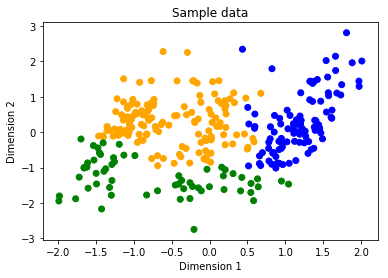

In [48]:
nr.seed(5555)
agglomerative3_a = AgglomerativeClustering(n_clusters=3, linkage = 'average')
assignments3_a = agglomerative3_a.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a)

聚类分配更好地遵循数据结构，第三个簇右下方有两个外围点。

现在，执行下面单元格中的代码，使用完整或最大链接计算和显示3簇凝聚模型的聚类效果。

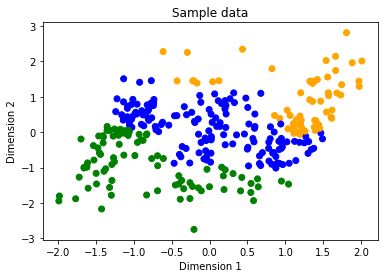

In [49]:
nr.seed(987)
agglomerative3_c = AgglomerativeClustering(n_clusters=3, linkage = 'complete')
assignments3_c = agglomerative3_c.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_c)

这些聚类与之前看到的完全不同。 但是，分配似乎与数据不一致。

尝试了几种连接功能后，您将探索使用不同的距离指标。 下面的单元格中的代码使用曼哈顿或l1距离度量来计算具有平均连接的3簇模型。 执行此代码并检查显示的类分配：


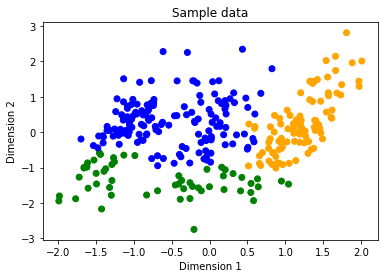

In [50]:
nr.seed(3344)
agglomerative3_a_m = AgglomerativeClustering(n_clusters=3, linkage = 'average', affinity = 'manhattan')
assignments3_a_m = agglomerative3_a_m.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a_m)

这些分配与使用平均连接和欧几里德距离获得的聚类分配相同。

可以尝试一些距离度量和连接的其他组合。 尝试平均连接和余弦相似性，执行下面单元格中的代码，使用平均连接和余弦相似度计算和显示3聚模型的效果。

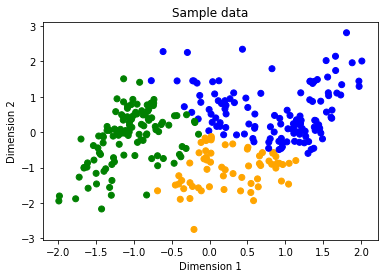

In [51]:
nr.seed(234)
agglomerative3_a_c = AgglomerativeClustering(n_clusters=3, linkage = 'average', affinity = 'cosine')
assignments3_a_c = agglomerative3_a_c.fit_predict(sample_2[:,0:2])
plot_clusters(sample_2, assignments3_a_c)

与其他度量选择一样，将数据划分看起来有点凌乱。

最后，计算每个模型的SC，并通过执行下面单元格中的代码来比较它们：

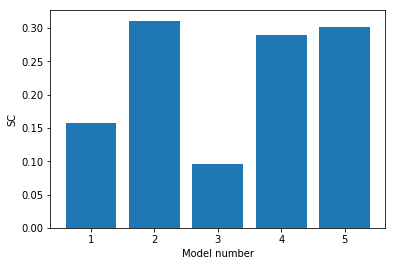

In [52]:
assignment_list = [assignments3_w, assignments3_a, assignments3_c, assignments3_a_m, assignments3_a_c]
plot_sillohette(sample, assignment_list, x_lab = 'Model number', start = 1)

具有Ward连接和欧几里德距离的第一个模型具有最高的SC。 使用平均连接和欧几里德或曼哈顿距离的三个群集模块几乎一样好。 从上述内容可以清楚地看出，距离度量和联系的选择可以对凝聚聚类的结果产生显着影响。


## 摘要

在本实验中，您使用了两种常用的聚类模型，K-means聚类和分层聚合聚类。这些方法是无监督学习的例子，因为它们试图在不使用标签或标记的情况下在数据中找到有趣的结构。

对于凝聚性群集模型，链接可以是以下任何一种：
 -  **Ward**或方差增加，
 -  **平均**连接或成对簇之间的平均成对距离，
 -  **完全**或**最大**连接或两个簇的成员之间的最大距离。

几个不同的距离度量用于计算链接函数：
 -  **Euclidian**或**l2**，
 -  **曼哈顿**或**l1**，
 -  **余弦相似度**。

聚类模型的一个关键问题是确定聚类的数量，由于没有标签，因此必须通过可视化和指标的组合来执行模型选择。用于评估群集模型的度量标准包括：
 - **群集平方和（WCSS）**和**簇间集平方和（BCSS）**仅用于K均值聚类。理想情况下，一个好的K-menas集群模型应该具有小的WCSS和大的BCSS。
 - 大多数任何聚类模型都可以使用**轮廓系数（SC）**进行评估，SC测量群集内距离与距离最近的相邻群集的距离之间的比率。
